# dsciATAC analysis, 60K cells, GPU
Only cells in the 'Resting' state from the dsciATAC experiment are included in this analysis.

### Imports, data loading

In [1]:
%%time
import numpy as np
import scanpy as sc
import anndata
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import pandas as pd
from collections import OrderedDict

import sys
sys.path.insert(0, '..')
import time
import os

import cudf
import cupy as cp

from cuml.decomposition import PCA
from cuml.manifold import TSNE
from cuml.cluster import KMeans

import rapids_scanpy_funcs
import utils

import warnings
warnings.filterwarnings('ignore', 'Expected ')

CPU times: user 2.62 s, sys: 4.49 s, total: 7.11 s
Wall time: 13.7 s


In [2]:
import rmm

rmm.reinitialize(
    managed_memory=True, # Allows oversubscription
    pool_allocator=False, # default is False
    devices=1, # GPU device IDs to register. By default registers only GPU 0.
)

cp.cuda.set_allocator(rmm.rmm_cupy_allocator)

In [3]:
# PARAMETER SETUP

# filtering peaks
n_top_peaks = 25000 # Number of peaks to retain

# PCA
n_components = 50 # Number of principal components to compute

# t-SNE
tsne_n_pcs = 20 # Number of principal components to use for t-SNE

# KNN
n_neighbors = 10 # Number of nearest neighbors for KNN graph
knn_n_pcs = 50 # Number of principal components to use for finding nearest neighbors

# UMAP
umap_min_dist = 0.4 
umap_spread = 1.0

# Differential peaks
n_diff_peaks = 50 # Number of differential peaks to compute for each cluster

# Marker genes
# Gene coordinates are in GRCh37, from grch37.ensembl.org
genes = OrderedDict()
genes['MS4A1'] = ['chr11', 60223225, 60238233, 'fwd']
genes['CD3D'] = ['chr11', 118209669, 118213459, 'rev']
genes['LEF1'] = ['chr4', 108968701, 109090112, 'rev']
genes['NKG7'] = ['chr19', 51874860, 51875969, 'rev']
genes['TREM1'] = ['chr6', 41235664, 41254457, 'rev']
genes['LYZ'] = ['chr12', 69742121, 69748014, 'fwd']
genes['GATA1'] = ['chrX', 48644962, 48652716, 'fwd']
genes['PAX5'] = ['chr9', 36833272, 37034103, 'rev']
genes_to_plot = ['MS4A1', 'LEF1', 'NKG7', 'TREM1', 'GATA1', 'PAX5']

In [4]:
start_time = time.time()

The dataset we use here comes from the dsciATAC paper ([Lareau et al., Nat Biotech 2019](https://www.nature.com/articles/s41587-019-0147-6)), one of the highest throughput single-cell ATAC-seq experiments to date. They assay 136K resting and stimulated bone marrow-derived cells and study the different cell types and lineages that emerge. The paper analyzes resting & stimulated cells separately (and we also find that these two populations split into largely distinct clusters), so here we only focus on the 60K resting cells from this experiment.

The cell metadata from this experiment includes annotated putative cell types based on chromVAR, Louvain clustering, and downstream cluster analysis. We compare our de novo identified clusters to these annotated clusters from the paper (and find good agreement).

The peak-cell matrix along with peak and cell metadata files are publicly available on GEO, [GSE123580](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE123580).

peak-cell mat: GSE123580/suppl/GSE123580_bonemarrow_countsData.csv.gz

peak metadata: GSE123580/suppl/GSE123580_bonemarrow_peaks.bed.gz

cell metadata: GSE123580/suppl/GSE123580_bonemarrow_cellData.tsv.gz

In [5]:
%%time
adata = anndata.read_h5ad('../data/dsci_resting_nonzeropeaks.h5ad')
adata_raw = adata.copy()

CPU times: user 422 ms, sys: 628 ms, total: 1.05 s
Wall time: 21.7 s


## Preprocessing

In [6]:
preprocessing_start = time.time()

### tf-idf normalization

We use log1p(pseudocount / tf)\*idf, motivated by discussion in [this blog post](http://andrewjohnhill.com/blog/2019/05/06/dimensionality-reduction-for-scatac-data/) as well as our results on various scATAC datasets.

In [7]:
%%time
lognormalized = utils.logtf_idf(adata.X, pseudocount=10**3)
adata.X = lognormalized

CPU times: user 2.37 s, sys: 877 ms, total: 3.24 s
Wall time: 3.24 s


### Frequency-based peak selection
We want to choose peaks that have highest discriminative power between cells. A good proxy for discriminative power is variance; since peak data (especially on a sparse dataset like this) is essentially binary, the highest variance peaks are the ones with closest to 50\% representation across cells (p=1/2 maximizes Bernoulli variance). The most frequent peak in this dataset only has 33\% representation, so in practice we just end up taking the top N most frequent peaks, where N is a parameter we set above (default 25000).

In [8]:
%%time
peak_frequency = np.array(np.sum(adata.X > 0, axis=0) / adata.X.shape[0]).flatten()
frequent_peak_idxs = np.argsort(peak_frequency)

CPU times: user 577 ms, sys: 117 ms, total: 695 ms
Wall time: 693 ms


In [9]:
%%time
use = frequent_peak_idxs[-n_top_peaks : ]
adata = adata[:, use]
adata = anndata.AnnData(X=adata.X.todense(),
                        obs=adata.obs,
                        var=adata.var
                       ) # for GPU PCA

CPU times: user 3.71 s, sys: 9.76 s, total: 13.5 s
Wall time: 13.5 s


In [10]:
print("Preprocessing time: %.2fsec" % (time.time() - preprocessing_start))

Preprocessing time: 17.44sec


## Cluster & Visualize

### PCA

In [11]:
%%time
adata.obsm["X_pca"] = PCA(n_components=n_components).fit_transform(adata.X)
adata.obsm["X_pca"].shape

CPU times: user 23.1 s, sys: 31.2 s, total: 54.3 s
Wall time: 54.3 s


(60495, 50)

### kNN + Louvain clustering, UMAP visualization

In [12]:
%%time
sc.pp.neighbors(adata, n_neighbors=n_neighbors, n_pcs=knn_n_pcs, method='rapids')

/raj-test/rapidsgenomics-2/lib/python3.7/site-packages/numba/np/ufunc/parallel.py:355: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 10005. The TBB threading layer is disabled.
  warnings.warn(problem)


CPU times: user 6.07 s, sys: 580 ms, total: 6.65 s
Wall time: 5.76 s


In [13]:
%%time
sc.tl.umap(adata, min_dist=umap_min_dist, spread=umap_spread, method='rapids')

CPU times: user 756 ms, sys: 568 ms, total: 1.32 s
Wall time: 1.39 s


In [14]:
%%time
sc.tl.louvain(adata, flavor='rapids', key_added='louvain_gpu')

CPU times: user 209 ms, sys: 105 ms, total: 314 ms
Wall time: 600 ms


/raj-test/rapidsgenomics-2/lib/python3.7/site-packages/cugraph/structure/graph.py:333: UserWarning: add_adj_list will be deprecated in next release. Use from_cudf_adjlist instead
  Use from_cudf_adjlist instead')


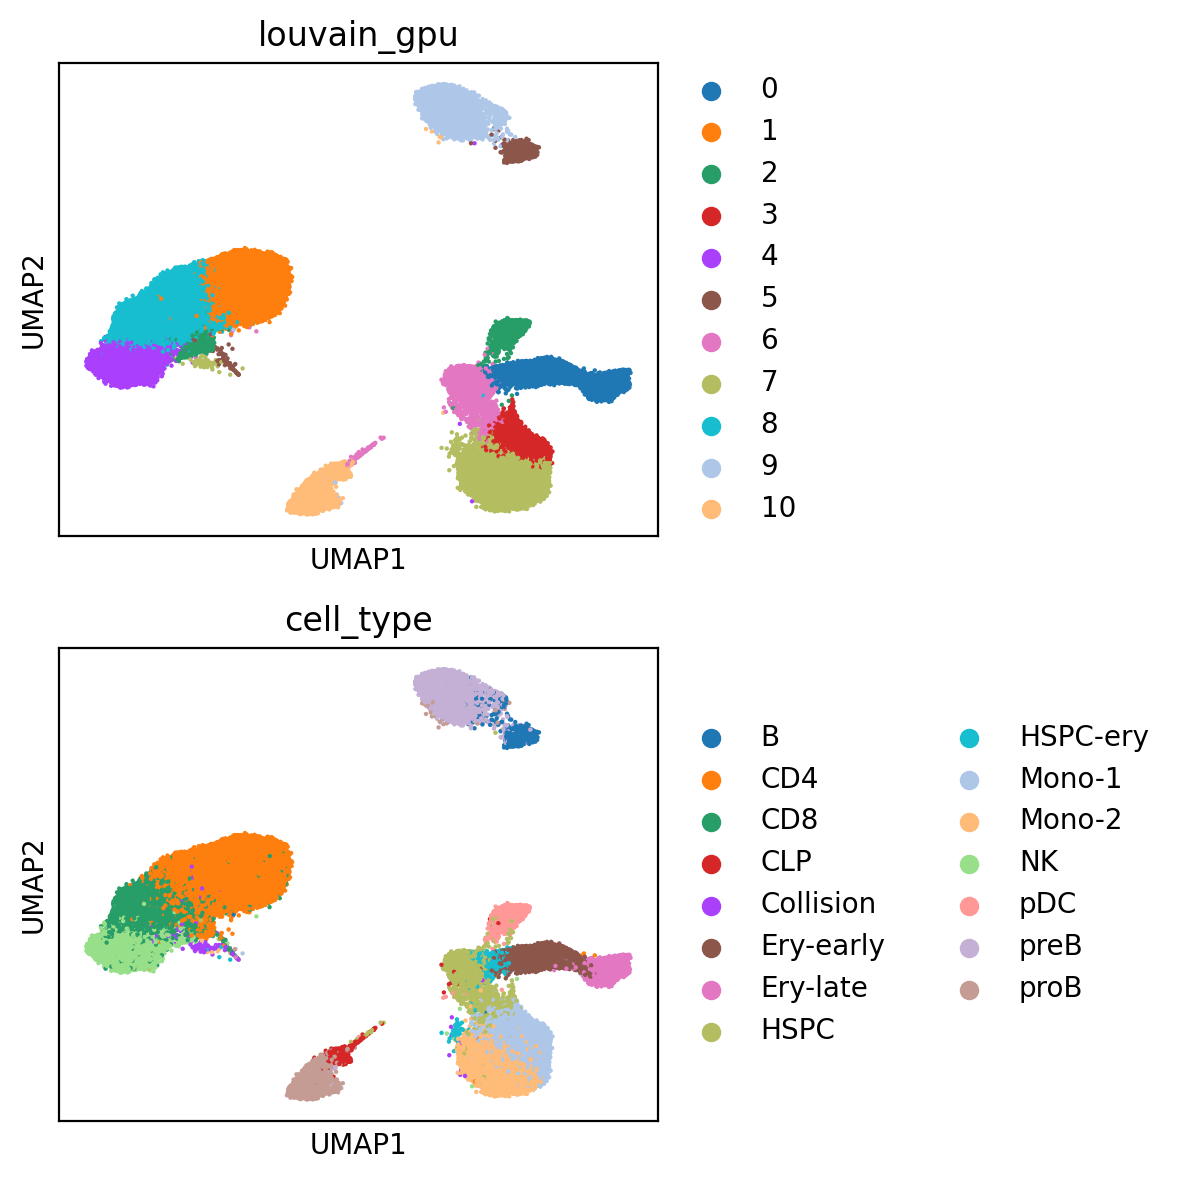

CPU times: user 2.46 s, sys: 203 ms, total: 2.66 s
Wall time: 2.47 s


In [24]:
%%time

fig, axs = plt.subplots(nrows = 2, ncols = 1, figsize = (6, 6), dpi=200)

sc.pl.umap(adata, color=['louvain_gpu'], s=10, ax=axs[0], show=False)
sc.pl.umap(adata, color=['cell_type'], s=10, ax=axs[1], show=False)

plt.tight_layout()
plt.savefig('../images/60k_bmmc_dsciATAC.png')
plt.show()

### tSNE visualization

In [16]:
%%time
adata.obsm['X_tsne'] = TSNE().fit_transform(adata.obsm["X_pca"][:, :tsne_n_pcs])

CPU times: user 932 ms, sys: 1.63 s, total: 2.56 s
Wall time: 2.54 s


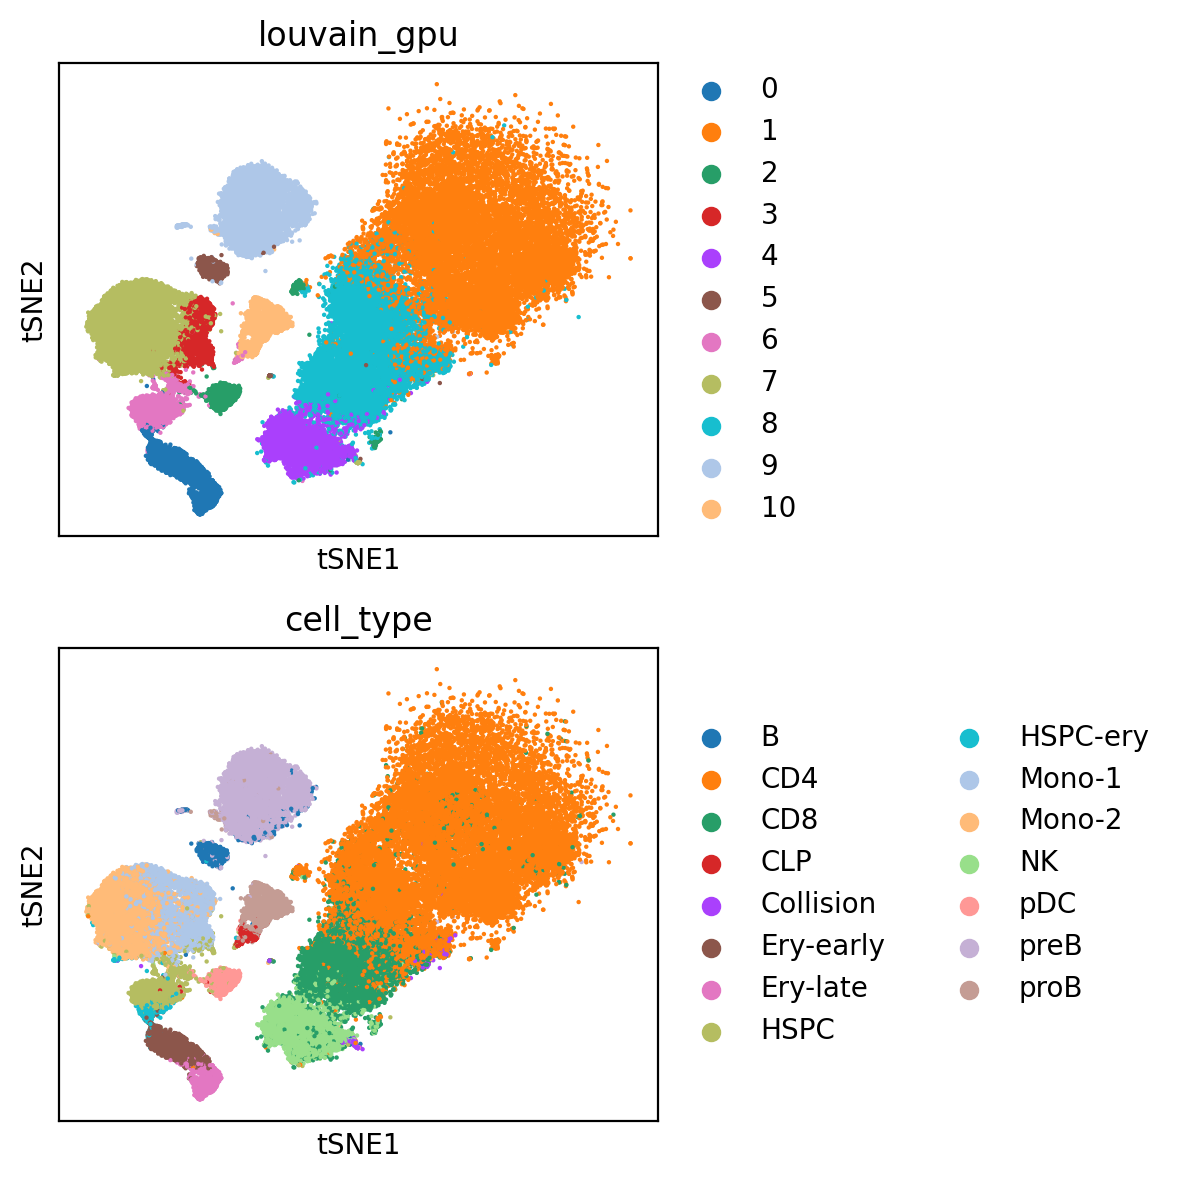

CPU times: user 1.21 s, sys: 211 ms, total: 1.42 s
Wall time: 1.17 s


In [17]:
%%time

fig, axs = plt.subplots(nrows = 2, ncols = 1, figsize = (6, 6), dpi=200)

sc.pl.tsne(adata, color=['louvain_gpu'], s=10, ax=axs[0], show=False)
sc.pl.tsne(adata, color=['cell_type'], s=10, ax=axs[1], show=False)

plt.tight_layout()
plt.show()

### Marker genes

We use the raw adata object to compute gene activity scores. This allows us to consider all peaks, not just the subset we used for clustering and UMAP.

In [18]:
%%time
# find which peaks overlap with each marker gene
peaks_per_gene = {gene : [] for gene in genes_to_plot}

for (i, peak) in enumerate(adata_raw.var_names):
    chrom, coords = peak.strip().split(':')
    start, end = [int(c) for c in coords.split('-')]
    for gene in genes_to_plot:
        if utils.overlap(genes[gene], [chrom, start, end], 5000, 0):
            peaks_per_gene[gene].append((i, peak))

for gene in peaks_per_gene:
    print(f"{gene} has {len(peaks_per_gene[gene])} nearby peaks")
    
cell_gene_scores = np.zeros((adata.X.shape[0], len(genes.keys())))
for (i, gene) in enumerate(peaks_per_gene.keys()):
    indices = [x[0] for x in peaks_per_gene[gene]]
    peak_scores = adata_raw.X[:, indices].toarray()
    cell_gene_scores[:, i] = np.sum(peak_scores, axis=1)

for (i, gene) in enumerate(genes_to_plot):
    adata.obs[gene] = np.log2(cell_gene_scores[:, i].tolist())
    adata.obs.loc[np.isneginf(adata.obs[gene]), gene] = 0

MS4A1 has 2 nearby peaks
LEF1 has 30 nearby peaks
NKG7 has 4 nearby peaks
TREM1 has 5 nearby peaks
GATA1 has 6 nearby peaks
PAX5 has 30 nearby peaks
CPU times: user 2.47 s, sys: 0 ns, total: 2.47 s
Wall time: 2.47 s


/raj-test/rapidsgenomics-2/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log2


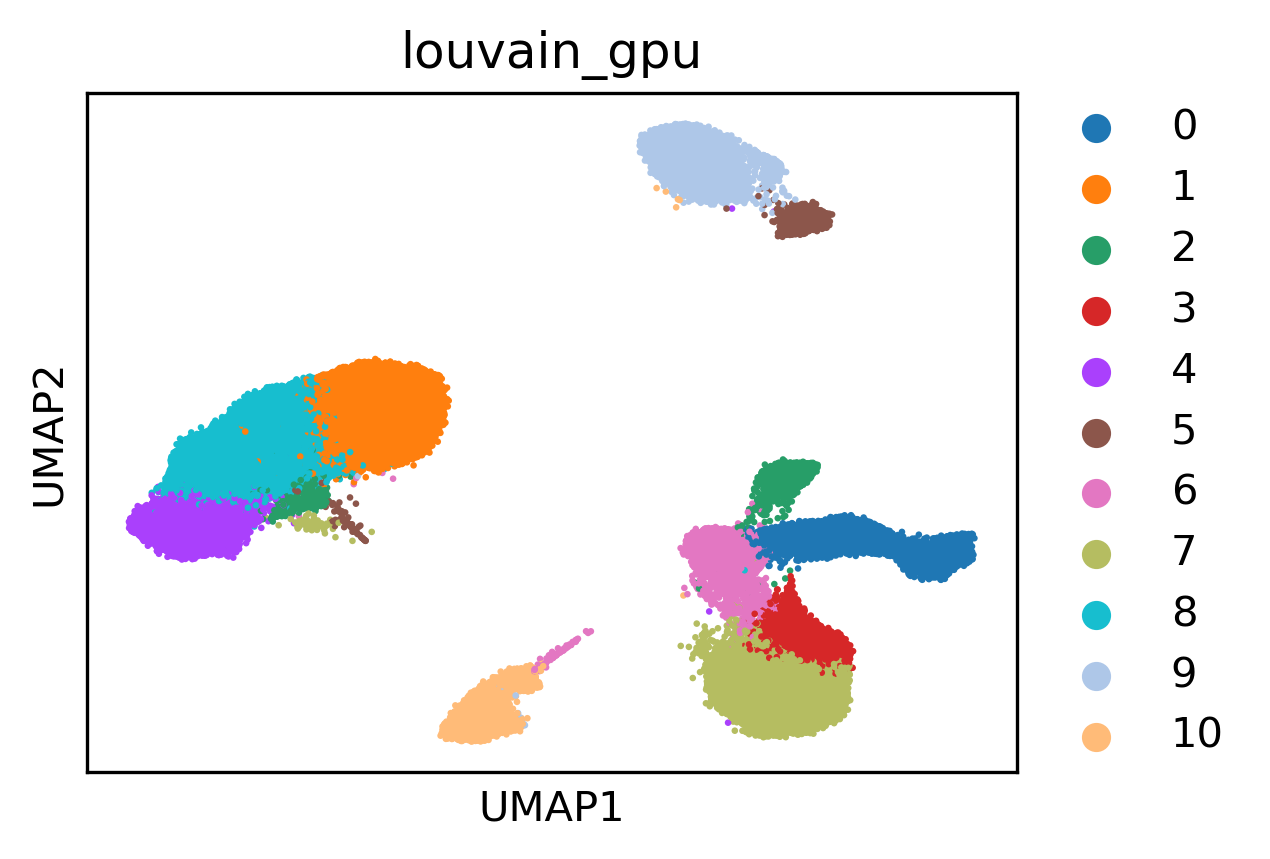

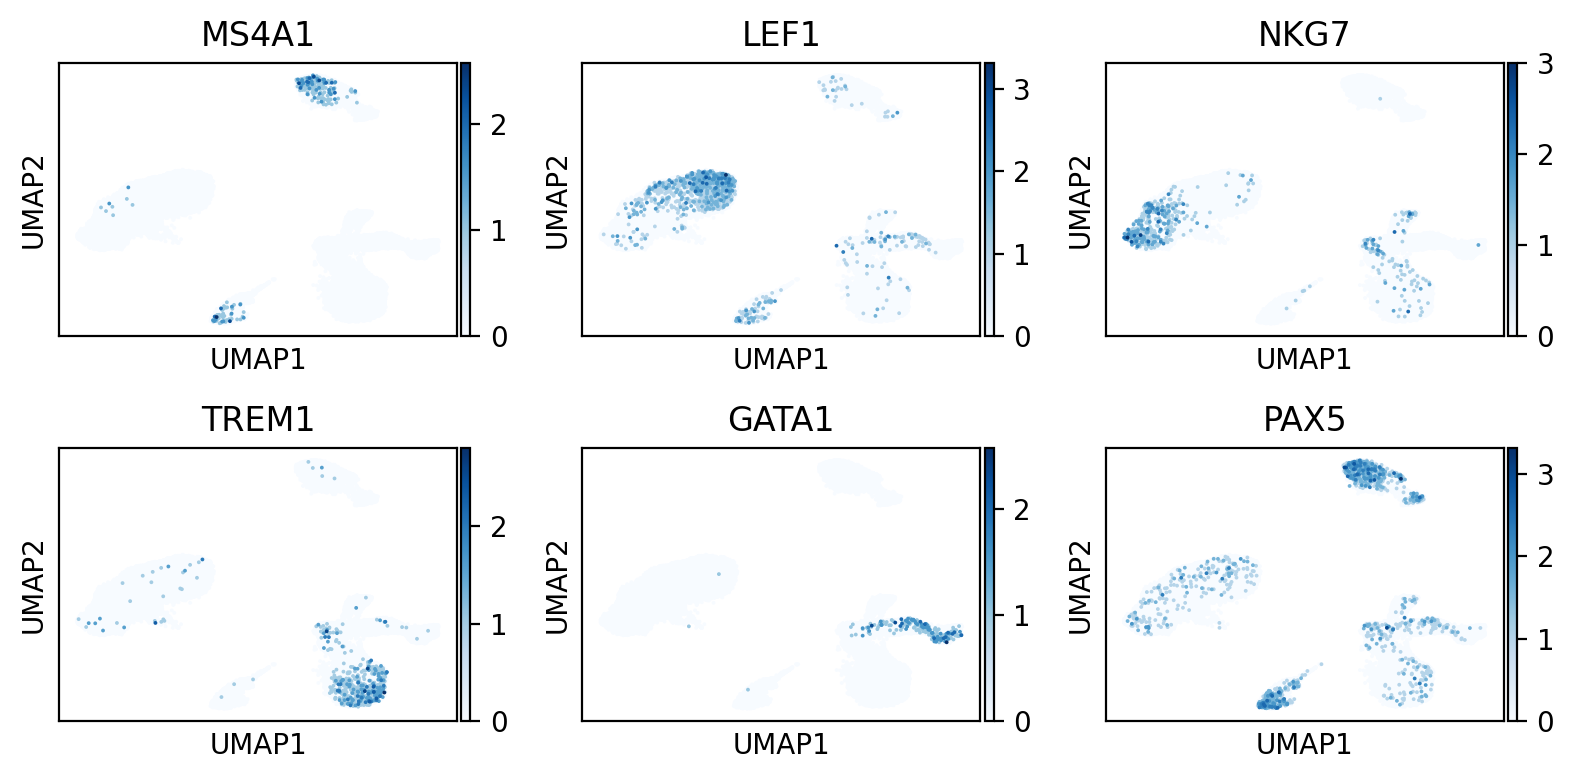

CPU times: user 2.98 s, sys: 177 ms, total: 3.15 s
Wall time: 2.89 s


In [19]:
%%time

plt.figure(figsize=(4,3), dpi=300)
sc.pl.umap(adata, color=['louvain_gpu'], s=10, ax=plt.gca(), show=True)

fig, axs = plt.subplots(nrows=2, ncols=3, figsize = (8, 4), dpi=200)
axs = axs.flatten()
for (i, gene) in enumerate(genes_to_plot):
    sc.pl.umap(adata, color_map="Blues", s=7.5, color=gene, ax = axs[i], show=False)
plt.tight_layout()
# plt.savefig('./figures/bmmc_60k_umap0.4_markergenes.png')
plt.show()

### Differential peaks

We perform an accelerated logistic regression-based differential peak computation using RAPIDS. However, the current release of RAPIDS (as of 4 Aug 2020) has a bug causing the output to be incorrect, so this function may not give entirely correct results. The bug will be fixed in a subsequent RAPIDS release, at which point this function should provide the same output as Scanpy's logreg differential peaks function.

In [20]:
%%time
cluster_labels = cudf.Series.from_categorical(adata.obs["louvain_gpu"].cat)
var_names = cudf.Series(adata.var_names)
dense_gpu_array = cp.array(adata.X)

CPU times: user 742 ms, sys: 4.05 s, total: 4.8 s
Wall time: 4.88 s


In [21]:
%%time
scores, names, reference = rapids_scanpy_funcs.rank_genes_groups(
    dense_gpu_array,
    cluster_labels, 
    var_names, 
    penalty='none',
    n_genes=n_diff_peaks, groups='all', reference='rest')

Ranking took (GPU): 17.140734672546387
Preparing output np.rec.fromarrays took (CPU): 0.0006117820739746094
Note: This operation will be accelerated in a future version
CPU times: user 8.51 s, sys: 9 s, total: 17.5 s
Wall time: 17.5 s


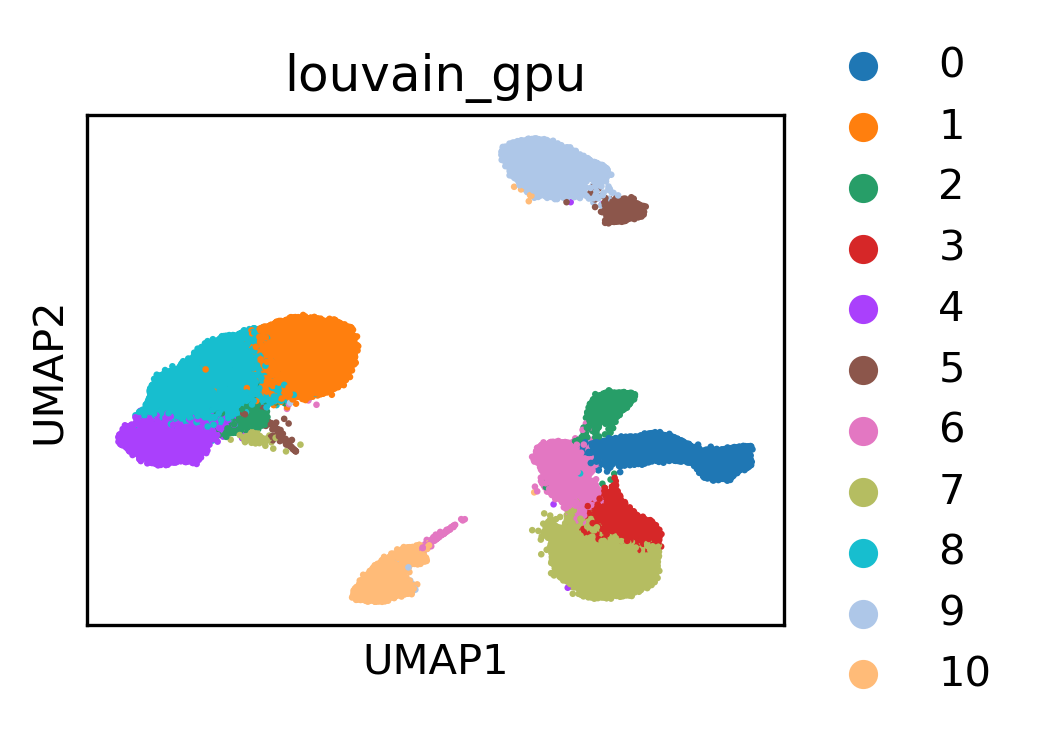

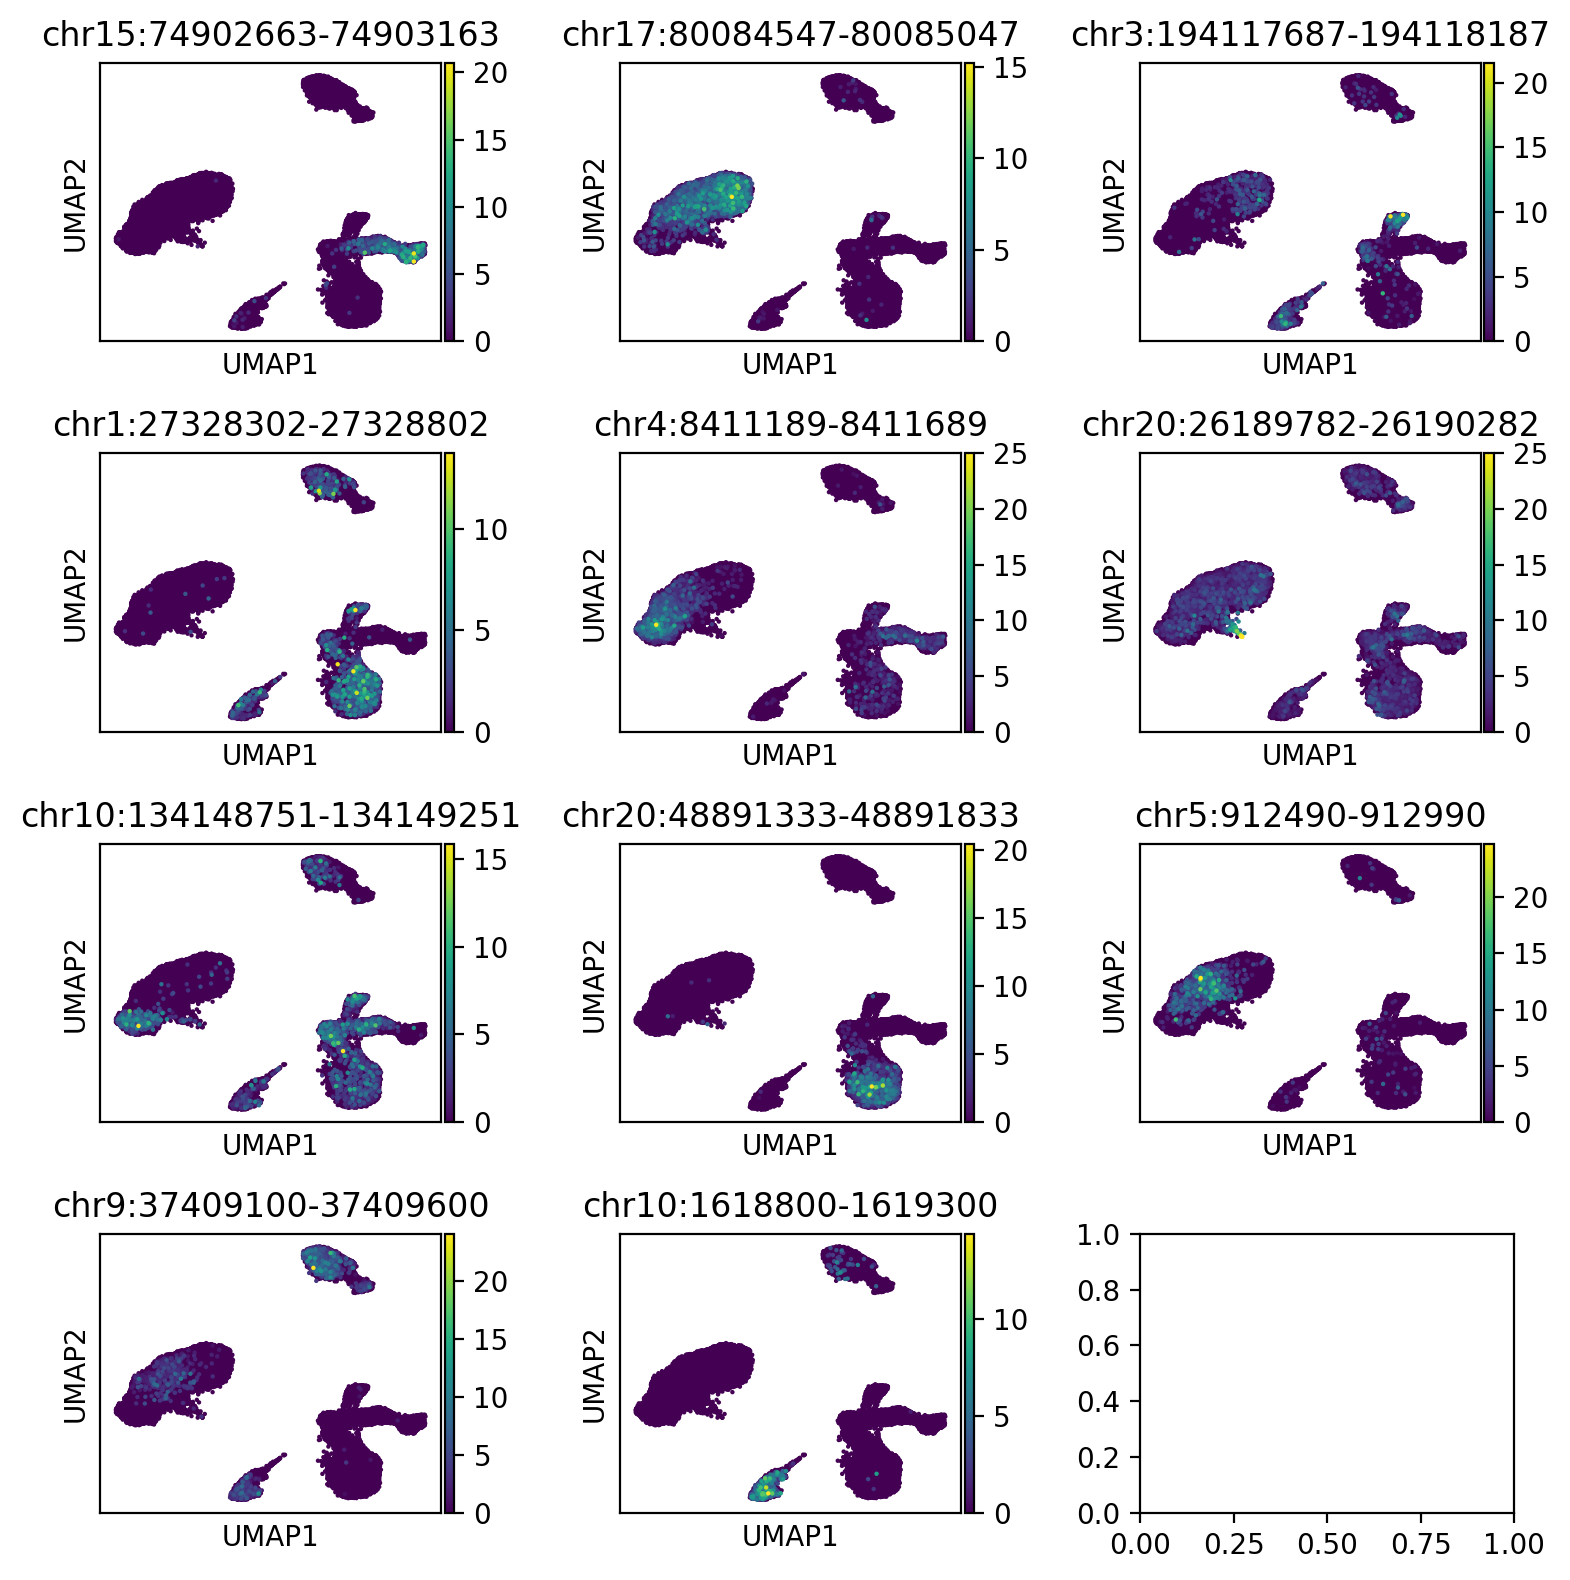

CPU times: user 5.81 s, sys: 140 ms, total: 5.95 s
Wall time: 5.69 s


In [22]:
%%time

fig = plt.figure(figsize=(3,2.25), dpi=300)
ax = plt.gca()

sc.pl.umap(adata, color=['louvain_gpu'], ax=ax, s=10)

# enough subplots to cover all clusters
fig, axs = plt.subplots(len(names[0])//3 + 1, 3, figsize=(8,8), dpi=200)
axs = axs.flatten()

for (i, peak) in enumerate(names[0]):
    sc.pl.umap(adata, color=peak, 
           ax=axs[i], s=10, show=False,
           vmax=min(25, np.max(adata[:,peak].X)),
           cmap='viridis'
          )
plt.tight_layout()
plt.show()

In [23]:
print("Full time: %.2fsec" % (time.time() - start_time))

Full time: 139.72sec
